# SETUP
---

## import packages

In [63]:
import numpy as np
import pandas as pd
import seaborn as sns

# matplotlib
import matplotlib.pyplot as plt
#from matplotlib.mlab import PCA as mlabPCA

# database packages
from sqlalchemy import create_engine

# sklearn
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale

# statsmodels
import statsmodels.api as sm

# scipy
from scipy import stats as st

import warnings
warnings.filterwarnings('ignore')

## set plot style

In [64]:
# import jtplot submodule from jupyterthemes
from jupyterthemes import jtplot

# currently installed theme will be used to
# set plot style if no arguments provided
jtplot.style()

## define database credentials

In [65]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

## query database & create dataframe

In [66]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

df.head(10)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,None,IR1,Lvl,AllPub,...,0,None,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,None,IR1,Lvl,AllPub,...,0,None,None,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,1,2008,WD,Normal,118000


# DATA CLEANING
---

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

## variable sorting

In [68]:
# get column names and type
df_cols = df.dtypes.to_frame().reset_index()
df_cols.columns = ['name','type']
df_cols.head()

,name,type
0,id,int64
1,mssubclass,int64
2,mszoning,object
3,lotfrontage,float64
4,lotarea,int64


In [69]:
# create containers for continuous and categorical variable names
cont_vars = df_cols[df_cols.type != 'object'].name.to_list()
cat_vars = df_cols[df_cols.type == 'object'].name.to_list()

In [70]:
# remove saleprice from cont_vars list
cont_vars.remove('saleprice')

# define target variable as saleprice
target_var = 'saleprice'

## check for missing values

In [71]:
# create new data frame
df_missing = pd.DataFrame()

# count NULL values for each column
df_missing['Count'] = df.isnull().sum().sort_values(ascending=False)

# calculate percentage of rows are NULL for each column
df_missing['Percent'] = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)*100

# view non-zero NULL counts
df_missing[df_missing.Count > 0]

,Count,Percent
poolqc,1453,99.520548
miscfeature,1406,96.301370
alley,1369,93.767123
fence,1179,80.753425
fireplacequ,690,47.260274
lotfrontage,259,17.739726
garagecond,81,5.547945
garagetype,81,5.547945
garageyrblt,81,5.547945
garagefinish,81,5.547945


##### For the moment, we will not drop any rows with NULL values. If we decide to use any of these variables as features, then we can address it at that time.

# DATA EXPLORATION
---

## saleprice distribution

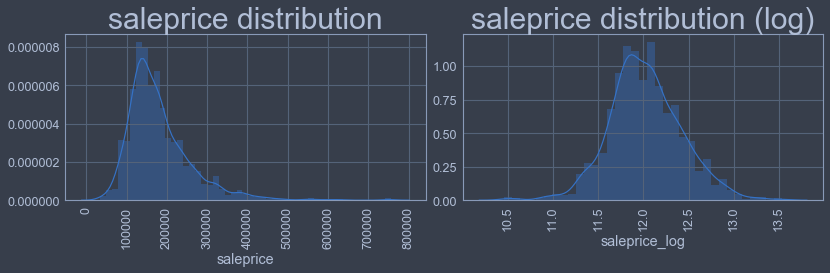

In [72]:
# set figure size
plt.rcParams["figure.figsize"] = (12,4)

# plot saleprice distribution
plt.subplot(1,2,1)
sns.distplot(df.saleprice)
plt.title('saleprice distribution', fontsize=30)
plt.xticks(rotation=90)

# log-transform saleprice and add to df
df['saleprice_log'] = np.log(df.saleprice)

# plot saleprice_log distribution
plt.subplot(1,2,2)
sns.distplot(df.saleprice_log)
plt.title('saleprice distribution (log)', fontsize=30)
plt.xticks(rotation=90)

plt.tight_layout()
plt.savefig('housing_prices_distplot_saleprice')
plt.show()

target_var = 'saleprice_log'

##### The transformed saleprice now resembles a normal distribution.

## inspect categorical variables

### saleprice split by categorical variables

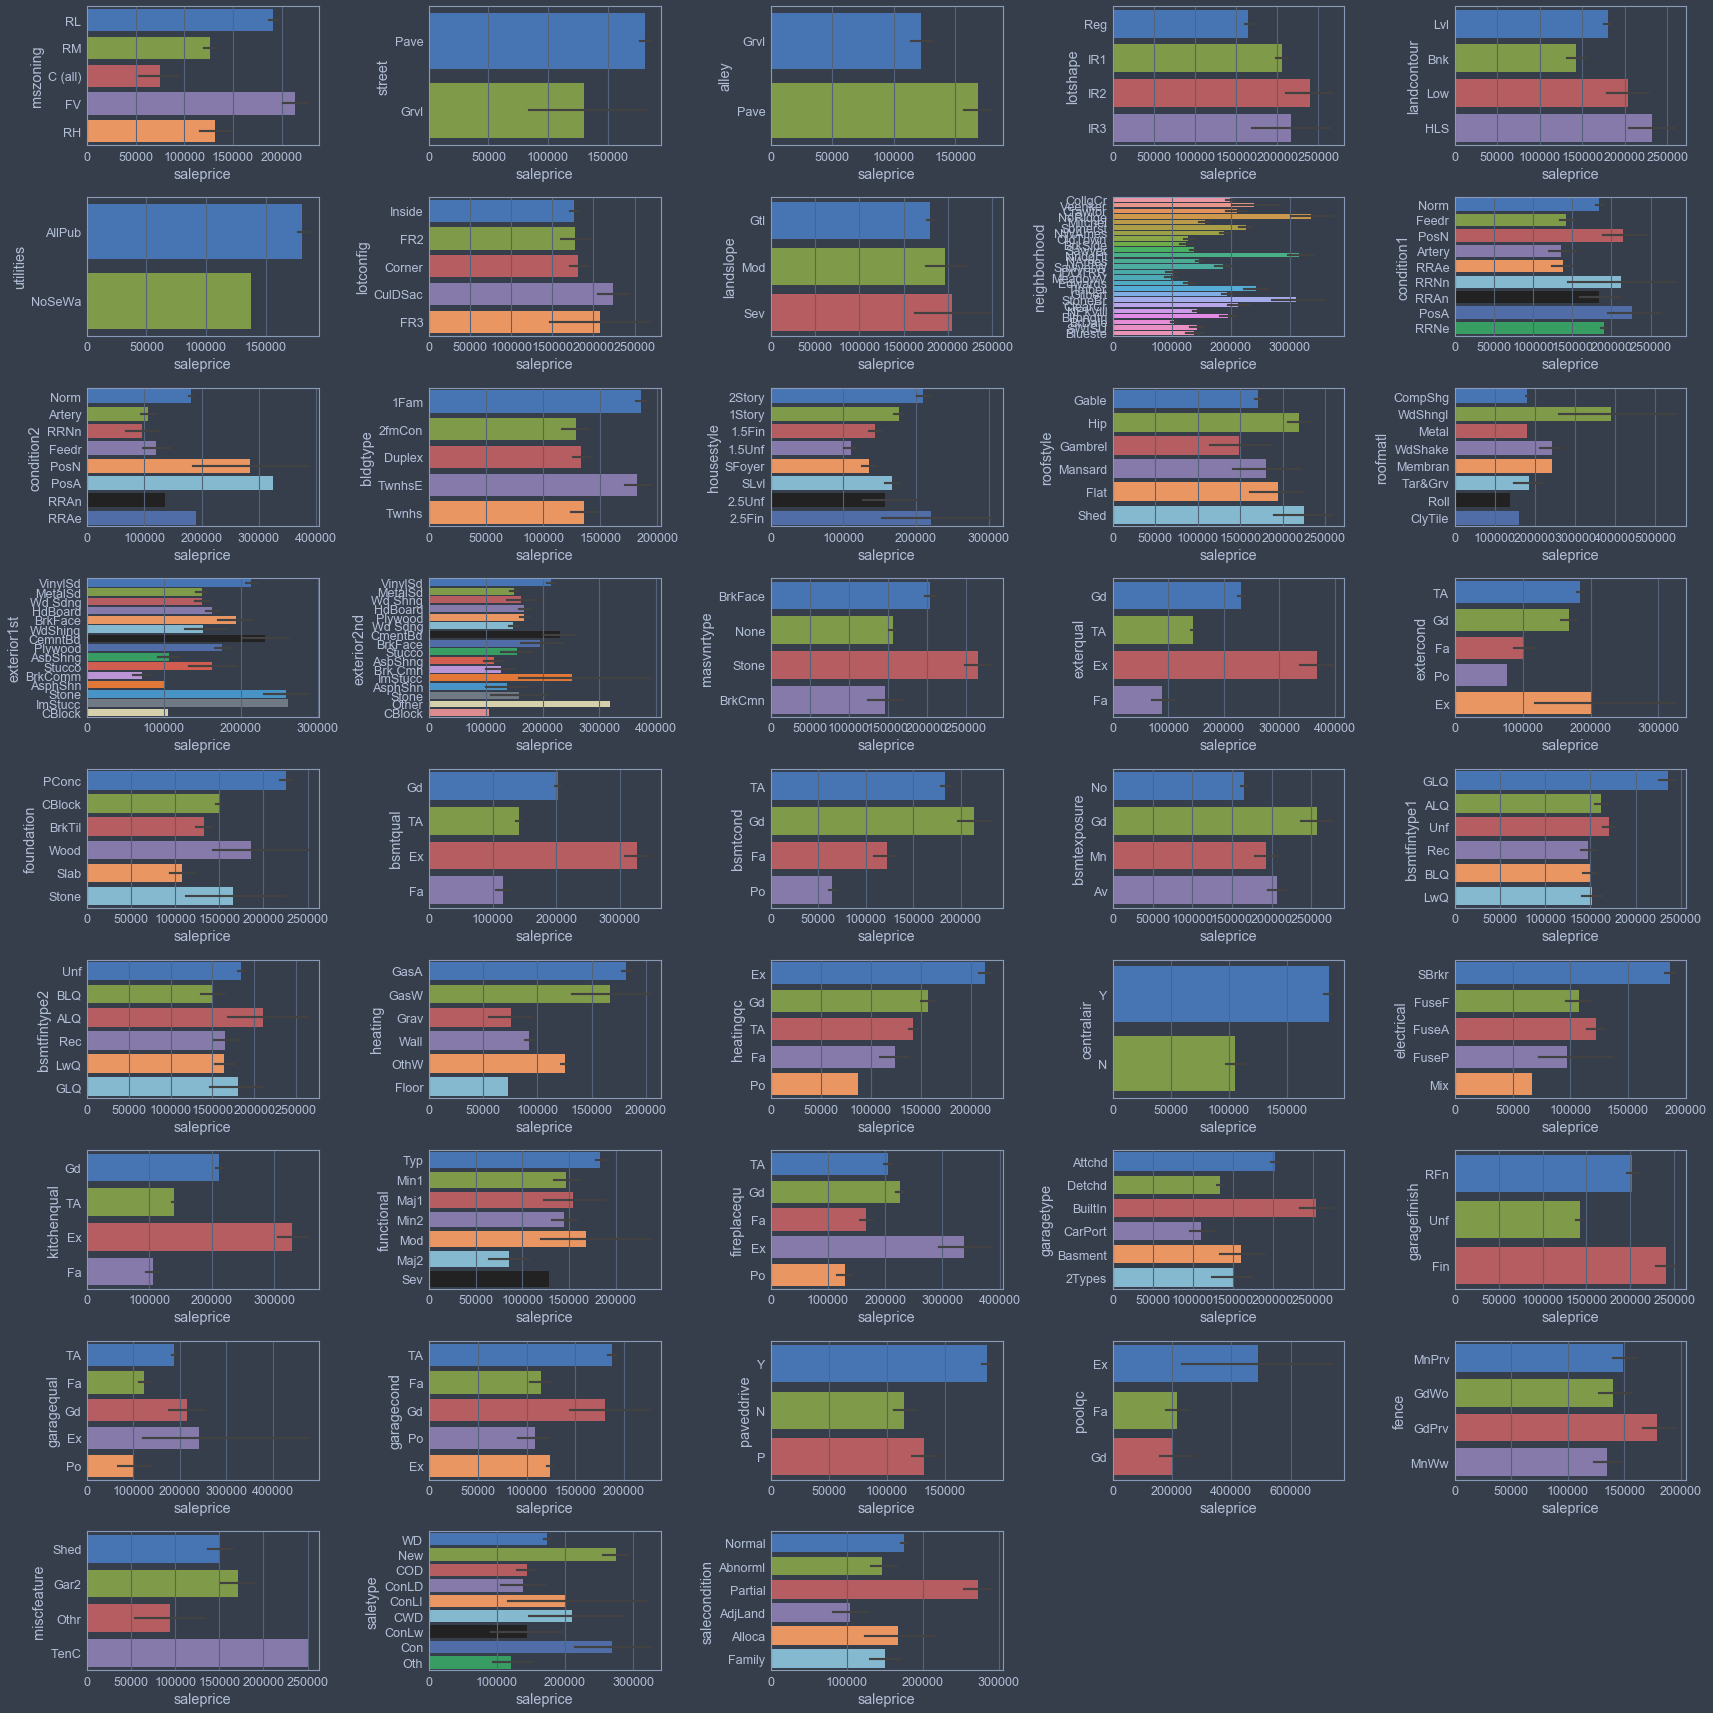

In [73]:
# set figure size
plt.rcParams['figure.figsize'] = (24,24)

# initialize subplot counter
i = 1

# iterate through list of categorical variables
for var in cat_vars:
    # plot each variable against saleprice
    plt.subplot(len(cat_vars)//5+1,5,i)
    sns.barplot(df.saleprice,df[var])
    i += 1

plt.tight_layout()
plt.savefig('housing_prices_barplot_cat_vars_vs_saleprice')
plt.show()

### count records per categorical variable group

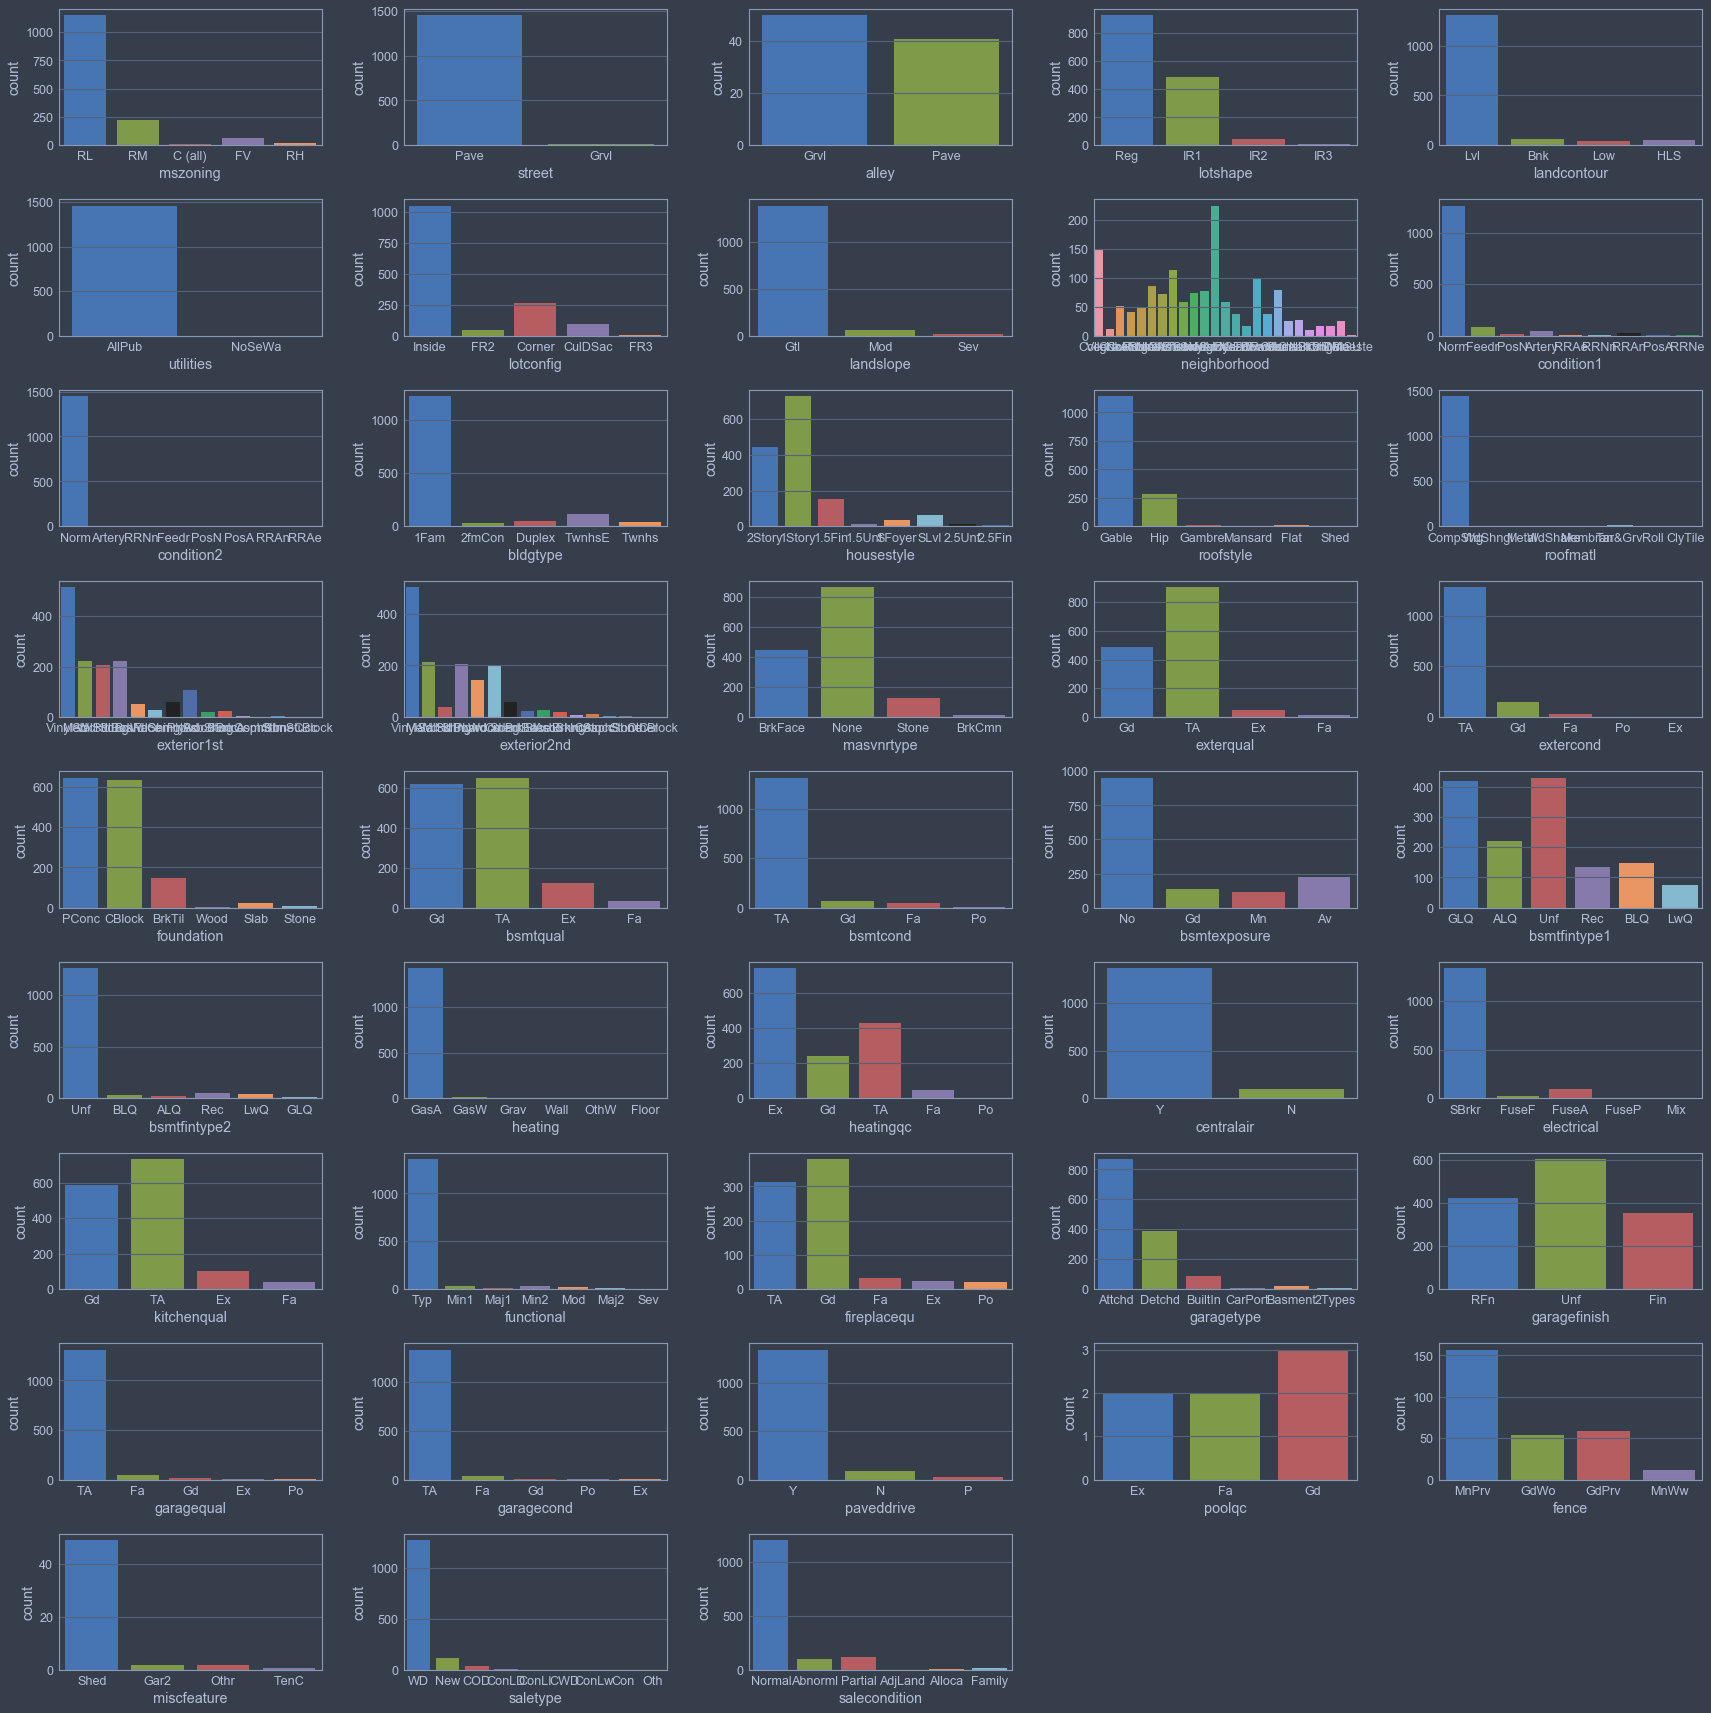

In [74]:
# set figure size
plt.rcParams['figure.figsize'] = (24,24)

# initialize subplot counter
i = 1

# iterate through list of categorical variables
for var in cat_vars:
    # plot count for each variable
    plt.subplot(len(cat_vars)//5+1,5,i)
    sns.countplot(df[var])
    i += 1

plt.tight_layout()
plt.savefig('housing_prices_countplot_cat_vars')
plt.show()

## correlation with saleprice

### regression plots

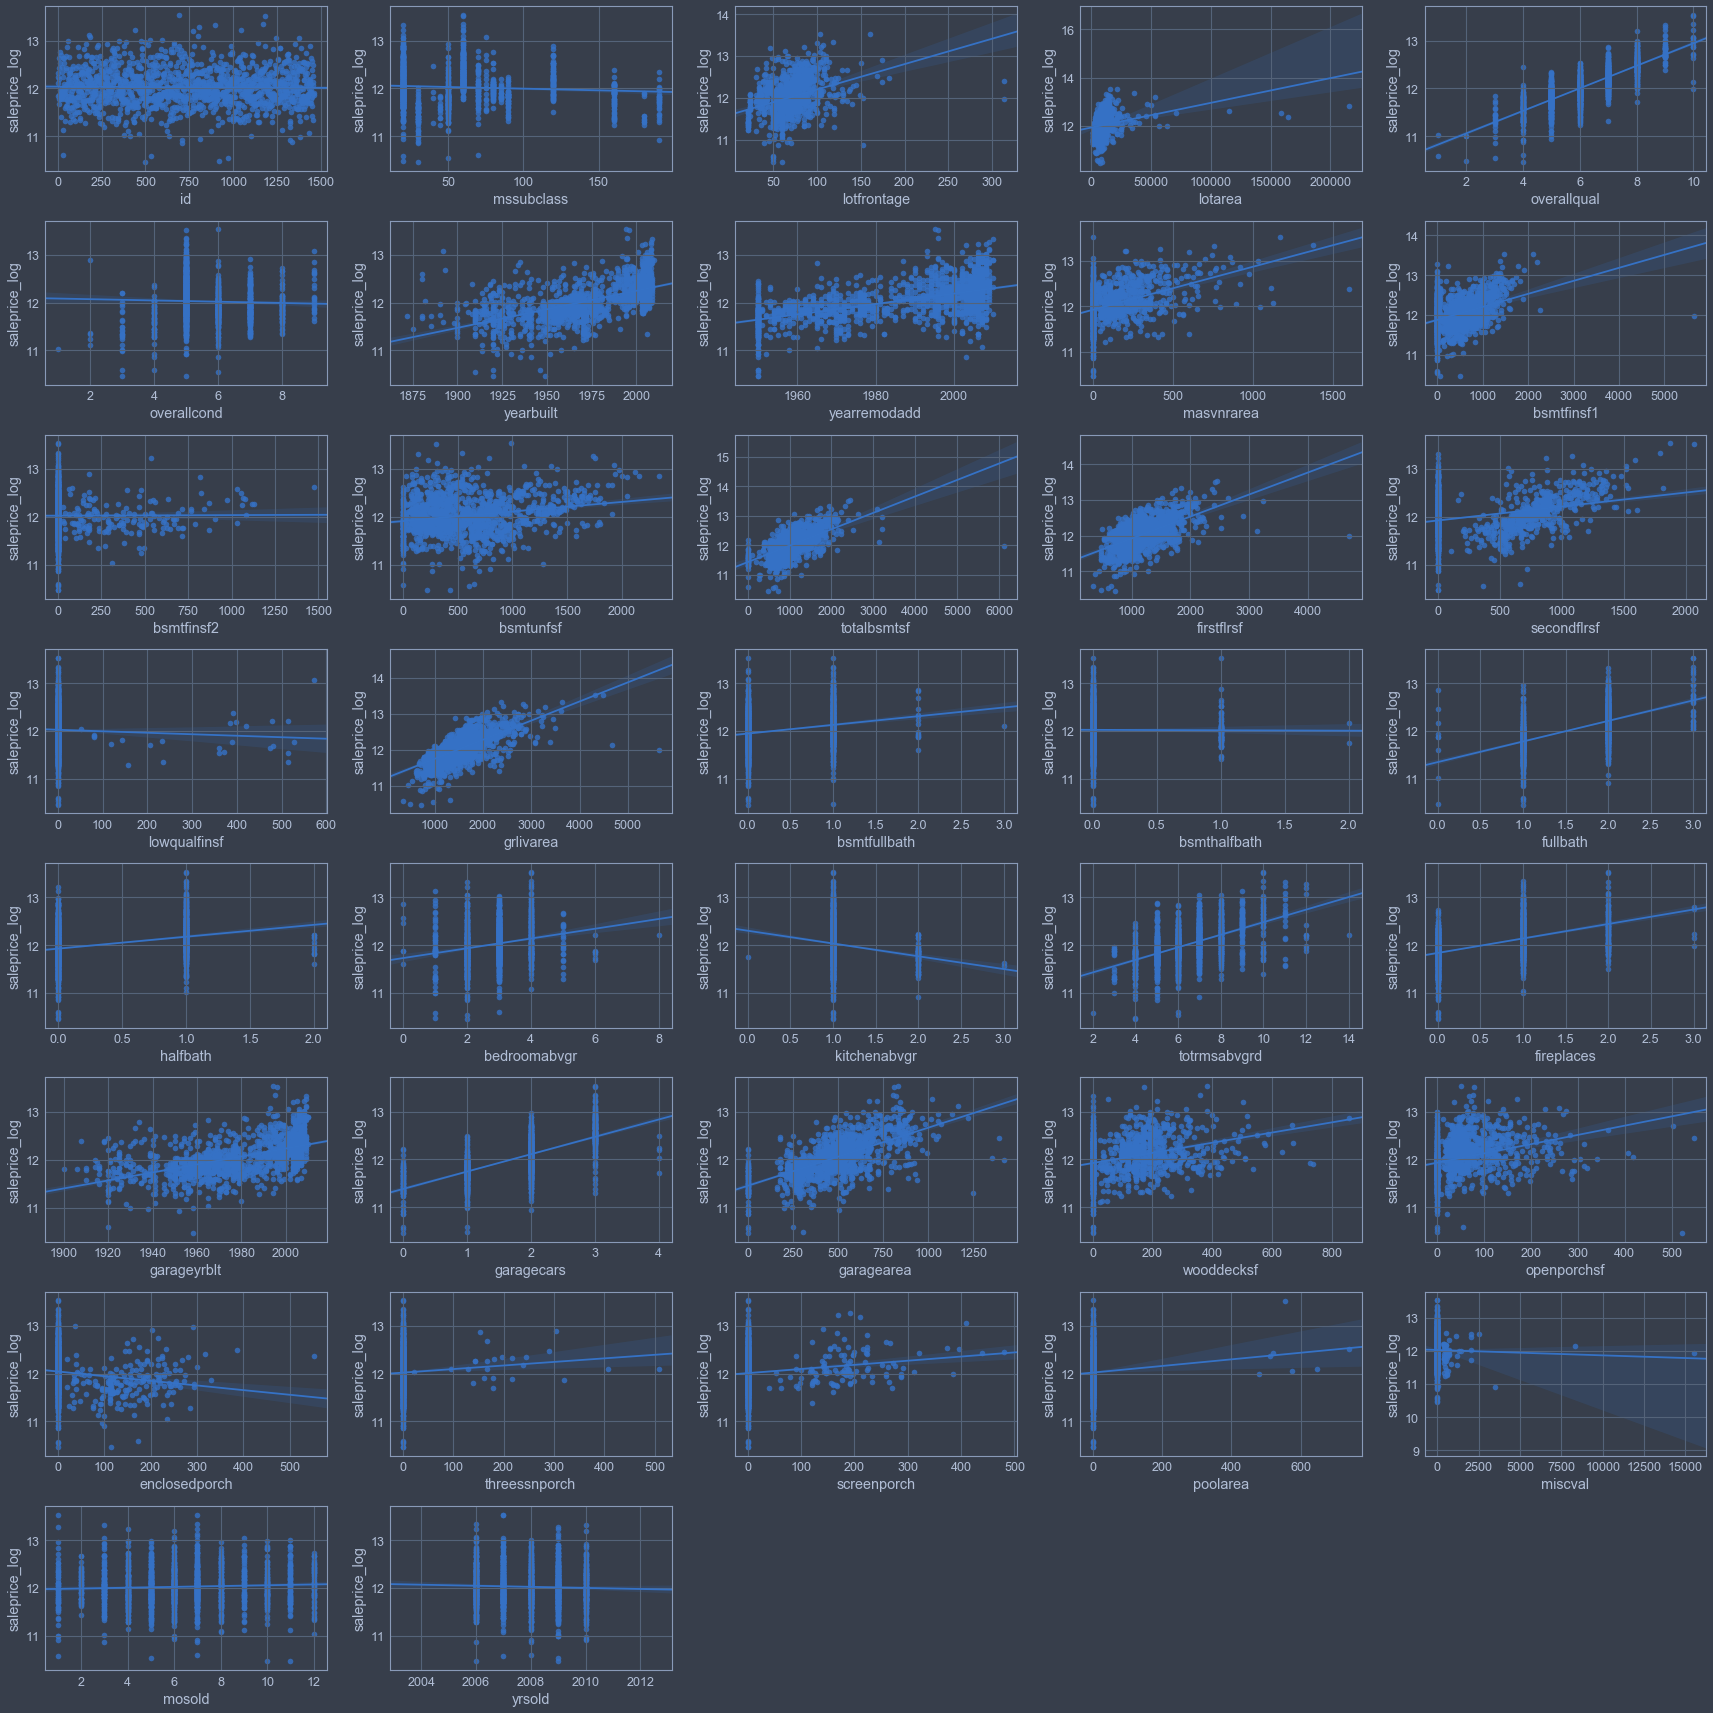

In [75]:
# set figure size
plt.rcParams['figure.figsize'] = (24,24)

# initialize subplot counter
i = 1

# iterate through list of categorical variables
for var in cont_vars:
    # plot each variable against saleprice
    plt.subplot(len(cont_vars)//5+1,5,i)
    sns.regplot(df[var],df.saleprice_log)
    i += 1

plt.tight_layout()
plt.savefig('housing_prices_regplot_salepricelog_vs_cont_vars')
plt.show()

##### There are multiple variables that correlate better with saleprice_log, but it is difficult to tell visually which are the best. Let's try a correlation matrix heatmap.

### correlation matrix

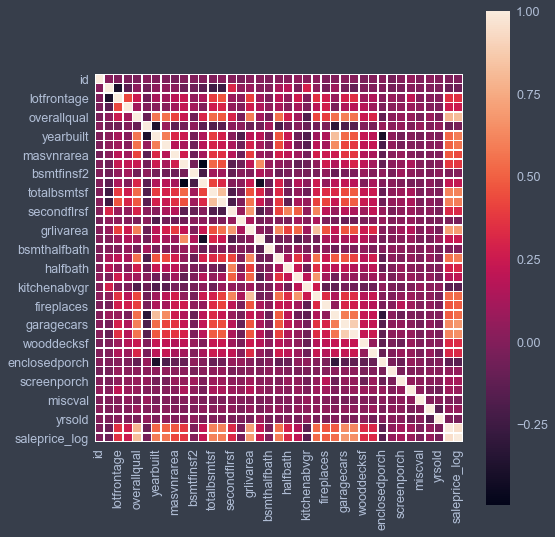

In [76]:
# set figure size
plt.rcParams['figure.figsize'] = (8,8)
sns.heatmap(df.corr(), square=True, linewidth=0.5)#, annot=True)

plt.tight_layout()
plt.show()

##### The heatmap above is a bit of an eye test. Instead let's focus on correlating with just saleprice_log.

In [77]:
df.corrwith(df.saleprice_log).sort_values(ascending=False)

saleprice_log    1.000000
saleprice        0.948374
overallqual      0.817184
grlivarea        0.700927
garagecars       0.680625
garagearea       0.650888
totalbsmtsf      0.612134
firstflrsf       0.596981
fullbath         0.594771
yearbuilt        0.586570
yearremodadd     0.565608
garageyrblt      0.541073
totrmsabvgrd     0.534422
fireplaces       0.489449
masvnrarea       0.430809
bsmtfinsf1       0.372023
lotfrontage      0.355878
wooddecksf       0.334135
openporchsf      0.321053
secondflrsf      0.319300
halfbath         0.313982
lotarea          0.257320
bsmtfullbath     0.236224
bsmtunfsf        0.221985
bedroomabvgr     0.209044
screenporch      0.121208
poolarea         0.069798
mosold           0.057329
threessnporch    0.054900
bsmtfinsf2       0.004832
bsmthalfbath    -0.005149
id              -0.017942
miscval         -0.020021
overallcond     -0.036868
yrsold          -0.037263
lowqualfinsf    -0.037963
mssubclass      -0.073959
kitchenabvgr    -0.147548
enclosedporc

##### That's much better. In correlating with saleprice_log, now we clearly see which are the top correlating continuous variables. Let's re-plot the top 5 for a better view.

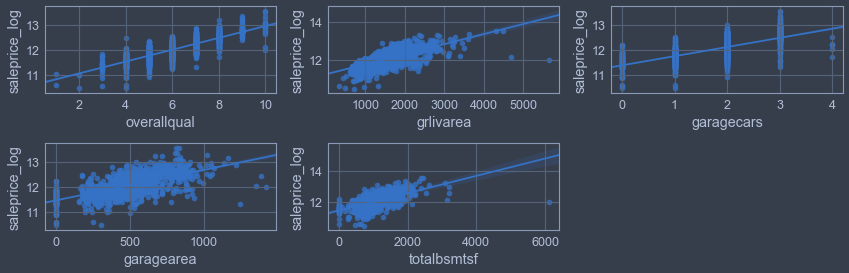

In [78]:
# set figure size
plt.rcParams['figure.figsize'] = (12,4)

# initialize subplot counter
i = 1

# iterate through list of categorical variables
for var in ['overallqual','grlivarea','garagecars','garagearea','totalbsmtsf']:
    # plot each variable against saleprice
    plt.subplot(2,3,i)
    sns.regplot(df[var],df.saleprice_log)
    i += 1

plt.tight_layout()
plt.savefig('housing_prices_regplot_salepricelog_vs_cont_vars_top5')
plt.show()

# FEATURE ENGINEERING
---

## feature selection

In [79]:
#cat_feats = ['neighborhood','housestyle','exterior1st','bsmtfintype1']
cat_feats = ['mszoning','street']
cont_feats = ['overallqual','grlivarea','garagecars','garagearea','totalbsmtsf']
features = cat_feats + cont_feats
allvars = [target_var] + features

# create new data frame with just the selected features and the targeted variable
df_feat = df[allvars].copy()
df_feat.head()

,saleprice_log,mszoning,street,overallqual,grlivarea,garagecars,garagearea,totalbsmtsf
0,12.247694,RL,Pave,7,1710,2,548,856
1,12.109011,RL,Pave,6,1262,2,460,1262
2,12.317167,RL,Pave,7,1786,2,608,920
3,11.849398,RL,Pave,7,1717,3,642,756
4,12.429216,RL,Pave,8,2198,3,836,1145


## one-hot encoding the categorical variables

In [80]:
# generate the one-hot encoding
dummies = pd.get_dummies(df_feat[cat_feats], drop_first=True)

# add the new columns to the data frame
features += dummies.columns.to_list()
df_feat = pd.concat([df_feat, dummies], axis=1)

# drop the original categorical variables replaced by their one-hot encoded versions
df_feat = df_feat.drop(cat_feats, axis=1).copy()

# view data frame
df_feat.head()

,saleprice_log,overallqual,grlivarea,garagecars,garagearea,totalbsmtsf,mszoning_FV,mszoning_RH,mszoning_RL,mszoning_RM,street_Pave
0,12.247694,7,1710,2,548,856,0,0,1,0,1
1,12.109011,6,1262,2,460,1262,0,0,1,0,1
2,12.317167,7,1786,2,608,920,0,0,1,0,1
3,11.849398,7,1717,3,642,756,0,0,1,0,1
4,12.429216,8,2198,3,836,1145,0,0,1,0,1


## feature trimming

### re-check correlation

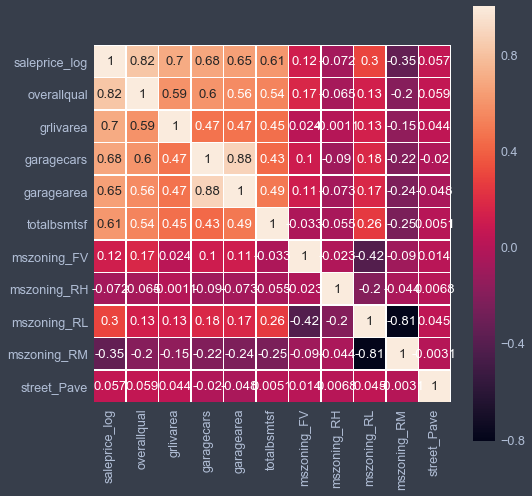

In [81]:
plt.rcParams['figure.figsize'] = (8,8)
#sns.heatmap(df_feat[cont_feats].corr(), square=True, annot=True, linewidth=0.5)
sns.heatmap(df_feat.corr(), square=True, annot=True, linewidth=0.5)
plt.show()

In [82]:
df_feat.corrwith(df_feat.saleprice_log).sort_values(ascending=False)

saleprice_log    1.000000
overallqual      0.817184
grlivarea        0.700927
garagecars       0.680625
garagearea       0.650888
totalbsmtsf      0.612134
mszoning_RL      0.298862
mszoning_FV      0.120312
street_Pave      0.057369
mszoning_RH     -0.072285
mszoning_RM     -0.347446
dtype: float64

In [83]:
# garagearea highly correlates with garagecars (eliminate garagearea)
# keep top correlating features
#features = ['overallqual','grlivarea','garagecars','totalbsmtsf','bsmtfintype1_GLQ','neighborhood_NridgHt','exterior1st_VinylSd']
features = ['overallqual','grlivarea','garagecars','totalbsmtsf']
df_feat = df_feat[[target_var] + features].copy()

In [84]:
df_feat.head()

,saleprice_log,overallqual,grlivarea,garagecars,totalbsmtsf
0,12.247694,7,1710,2,856
1,12.109011,6,1262,2,1262
2,12.317167,7,1786,2,920
3,11.849398,7,1717,3,756
4,12.429216,8,2198,3,1145


## execute PCA

In [85]:
#X = StandardScaler().fit_transform(df_feat[cont_feats])
X = StandardScaler().fit_transform(df_feat[features])

sklearn_pca = PCA(n_components=2)
#df_feat['PCA_1'] = sklearn_pca.fit_transform(X)
pca_data = sklearn_pca.fit_transform(X)

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_,
    '\n total = ',
    sum(sklearn_pca.explained_variance_ratio_)
)

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.63751659 0.14304907] 
 total =  0.7805656592312916


### add new PCA features into data frame

In [86]:
pca_1 = []
pca_2 = []
#pca_3 = []

for row in range(len(pca_data)):
    pca_1.append(pca_data[row][0])
    pca_2.append(pca_data[row][1])

# add PCA variables to data frame
df_feat['PCA_1'] = pca_1
df_feat['PCA_2'] = pca_2
features += ['PCA_1', 'PCA_2']

# view modified data frame
df_feat.head()

,saleprice_log,overallqual,grlivarea,garagecars,totalbsmtsf,PCA_1,PCA_2
0,12.247694,7,1710,2,856,0.472916,-0.667892
1,12.109011,6,1262,2,1262,0.095438,0.269929
2,12.317167,7,1786,2,920,0.612991,-0.562335
3,11.849398,7,1717,3,756,1.029219,-1.588151
4,12.429216,8,2198,3,1145,2.290764,-1.042790


### re-check correlation matrix

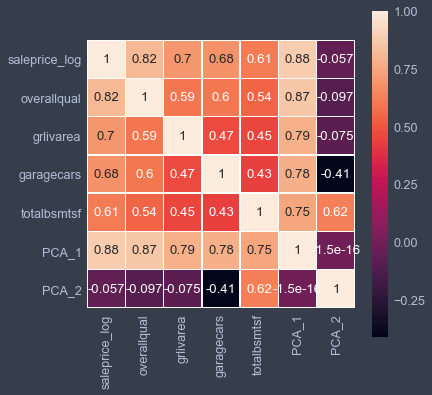

In [87]:
plt.rcParams['figure.figsize'] = (6,6)
sns.heatmap(df_feat.corr(), square=True, annot=True, linewidth=0.5)
plt.yticks(rotation=0)
plt.show()

In [30]:
df_feat.corrwith(df_feat[target_var]).sort_values()

PCA_2           -0.057105
totalbsmtsf      0.612134
garagecars       0.680625
grlivarea        0.700927
overallqual      0.817184
PCA_1            0.883717
saleprice_log    1.000000
dtype: float64

##### PCA_1 correlates well with overallqual, grlivarea, garagecars, and totalbsmtsf and better than these with saleprice_log. Therefore, PCA_1 can replace these 4 features.

### reduce data frame to final features

In [88]:
df_feat = df_feat[[target_var] + ['PCA_1','PCA_2']].copy()
df_feat.head()

,saleprice_log,PCA_1,PCA_2
0,12.247694,0.472916,-0.667892
1,12.109011,0.095438,0.269929
2,12.317167,0.612991,-0.562335
3,11.849398,1.029219,-1.588151
4,12.429216,2.290764,-1.042790


## Standardize/Normalize

In [89]:
df_feat_normstd = df_feat.copy()
# normalize the variables
for col in df_feat_normstd.columns:
    df_feat_normstd[col] = normalize(np.array(df_feat_normstd[col].dropna()).reshape(1,-1)).reshape(-1,1)

# standardize the variables
for col in df_feat_normstd.columns:
    df_feat_normstd[col] = scale(df_feat[col])

df_feat_normstd.head()

,saleprice_log,PCA_1,PCA_2
0,0.560068,0.296148,-0.882946
1,0.212764,0.059765,0.356843
2,0.734046,0.383865,-0.743401
3,-0.437382,0.644513,-2.099516
4,1.014651,1.434513,-1.378556


# REGRESSION
---

## linear regression w/statsmodels

In [42]:
# define target variable Y
Y = df_feat_normstd.saleprice_log

# define feature variable X
X = df_feat_normstd[['PCA_1','PCA_2']]

# add a constant
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          saleprice_log   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                     2648.
Date:                Wed, 22 Jan 2020   Prob (F-statistic):               0.00
Time:                        16:44:23   Log-Likelihood:                -952.21
No. Observations:                1460   AIC:                             1910.
Df Residuals:                    1457   BIC:                             1926.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.905e-15      0.012  -1.57e-13      1.000      -0.024       0.024
PCA_1          0.8837      0.012     72.616      0.000       0.860       0.908
PCA_2         -0.0571      0.012     -4.692      0.000      -0.081      -0.033
==============================================================================
Omnibus:                      883.161   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            22703.474
Skew:                          -2.343   Prob(JB):                         0.00
Kurtosis:                      21.742   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## linear regression with sklearn

In [43]:
# We create a LinearRegression model object
# from scikit-learn's linear_model module.
lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [ 0.          0.88371652 -0.05710466]

Intercept: 
 -1.892815818746862e-15
